In [1]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=4

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=4


In [2]:
import mbuild as mb
import foyer
import mosdef_cassandra as mc
import unyt as u
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import numpy as np

from scipy.stats import linregress

from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd
from mosdef_cassandra.utils.get_files import get_example_ff_path, get_example_mol2_path

# Filter some warnings -- to cleanup output for this demo
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)
from parmed.exceptions import OpenMMWarning
filterwarnings('ignore', category=OpenMMWarning)
warnings.filterwarnings('ignore')


mpl.rcParams["axes.linewidth"] =  1.5
mpl.rcParams["axes.grid"] = False

mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.right"] = True

mpl.rcParams["xtick.major.width"] = 1.5
mpl.rcParams["ytick.major.width"] = 1.5
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["xtick.minor.width"] = 1.0
mpl.rcParams["ytick.minor.width"] = 1.0
mpl.rcParams["xtick.minor.size"] =  2.5
mpl.rcParams["ytick.minor.size"] =  2.5
mpl.rcParams["xtick.direction"] =  'in'
mpl.rcParams["ytick.direction"] =  'in'
mpl.rcParams["xtick.major.size"] =  5
mpl.rcParams["ytick.major.size"] =  5

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] ='bold'
mpl.rcParams['font.size'] = 12.0
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

%matplotlib inline



def set_ticks(ax, xlinear=True, ylinear=False, xmax=False, ymax=True, yticks = 5, xticks = 5):
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(6))
    if xlinear: ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(xticks))
    if xmax: ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(xticks))
    if ylinear: ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(yticks))
    if ymax: ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(yticks))





In [3]:
#adsorbate = mb.load(get_example_mol2_path("spce"))
#ff = foyer.Forcefield(get_example_ff_path("spce"))


rOH =  0.09526 # nm
rOM = 0.01250 # nm
thetaHOH =  104.52  # degrees

x = thetaHOH * np.pi / 180.0 / 2

adsorbate = mb.Compound()
o = mb.Particle(name='O', pos=[0.0, 0.0, 0.0])
h1 = mb.Particle(name='H', pos=[0.0, rOH * np.cos(x), rOH * np.sin(x)])
h2 = mb.Particle(name='H', pos=[0.0, rOH * np.cos(x), -rOH * np.sin(x)])
m =  mb.Particle(name='_M', pos=[0.0, rOM, 0.0])
adsorbate.add([o, h1, h2, m])
adsorbate.add_bond((o, h1))
adsorbate.add_bond((o, h2))
adsorbate.add_bond((o, m))

ff = foyer.Forcefield("tip4p_ew.xml")


adsorbate_ff = ff.apply(adsorbate)
adsorbate.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
temperature = 373.0 * u.K

custom_args = {
  "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "charge_cutoff": 14.0 * u.angstrom,
    "prop_freq": 1000,
    "coord_freq": 1000,
    "angle_style": ['fixed'], # Only for riged molecules! 
}



mus_adsorbate = np.arange(-58, -48, 2) * u.kJ/u.mol


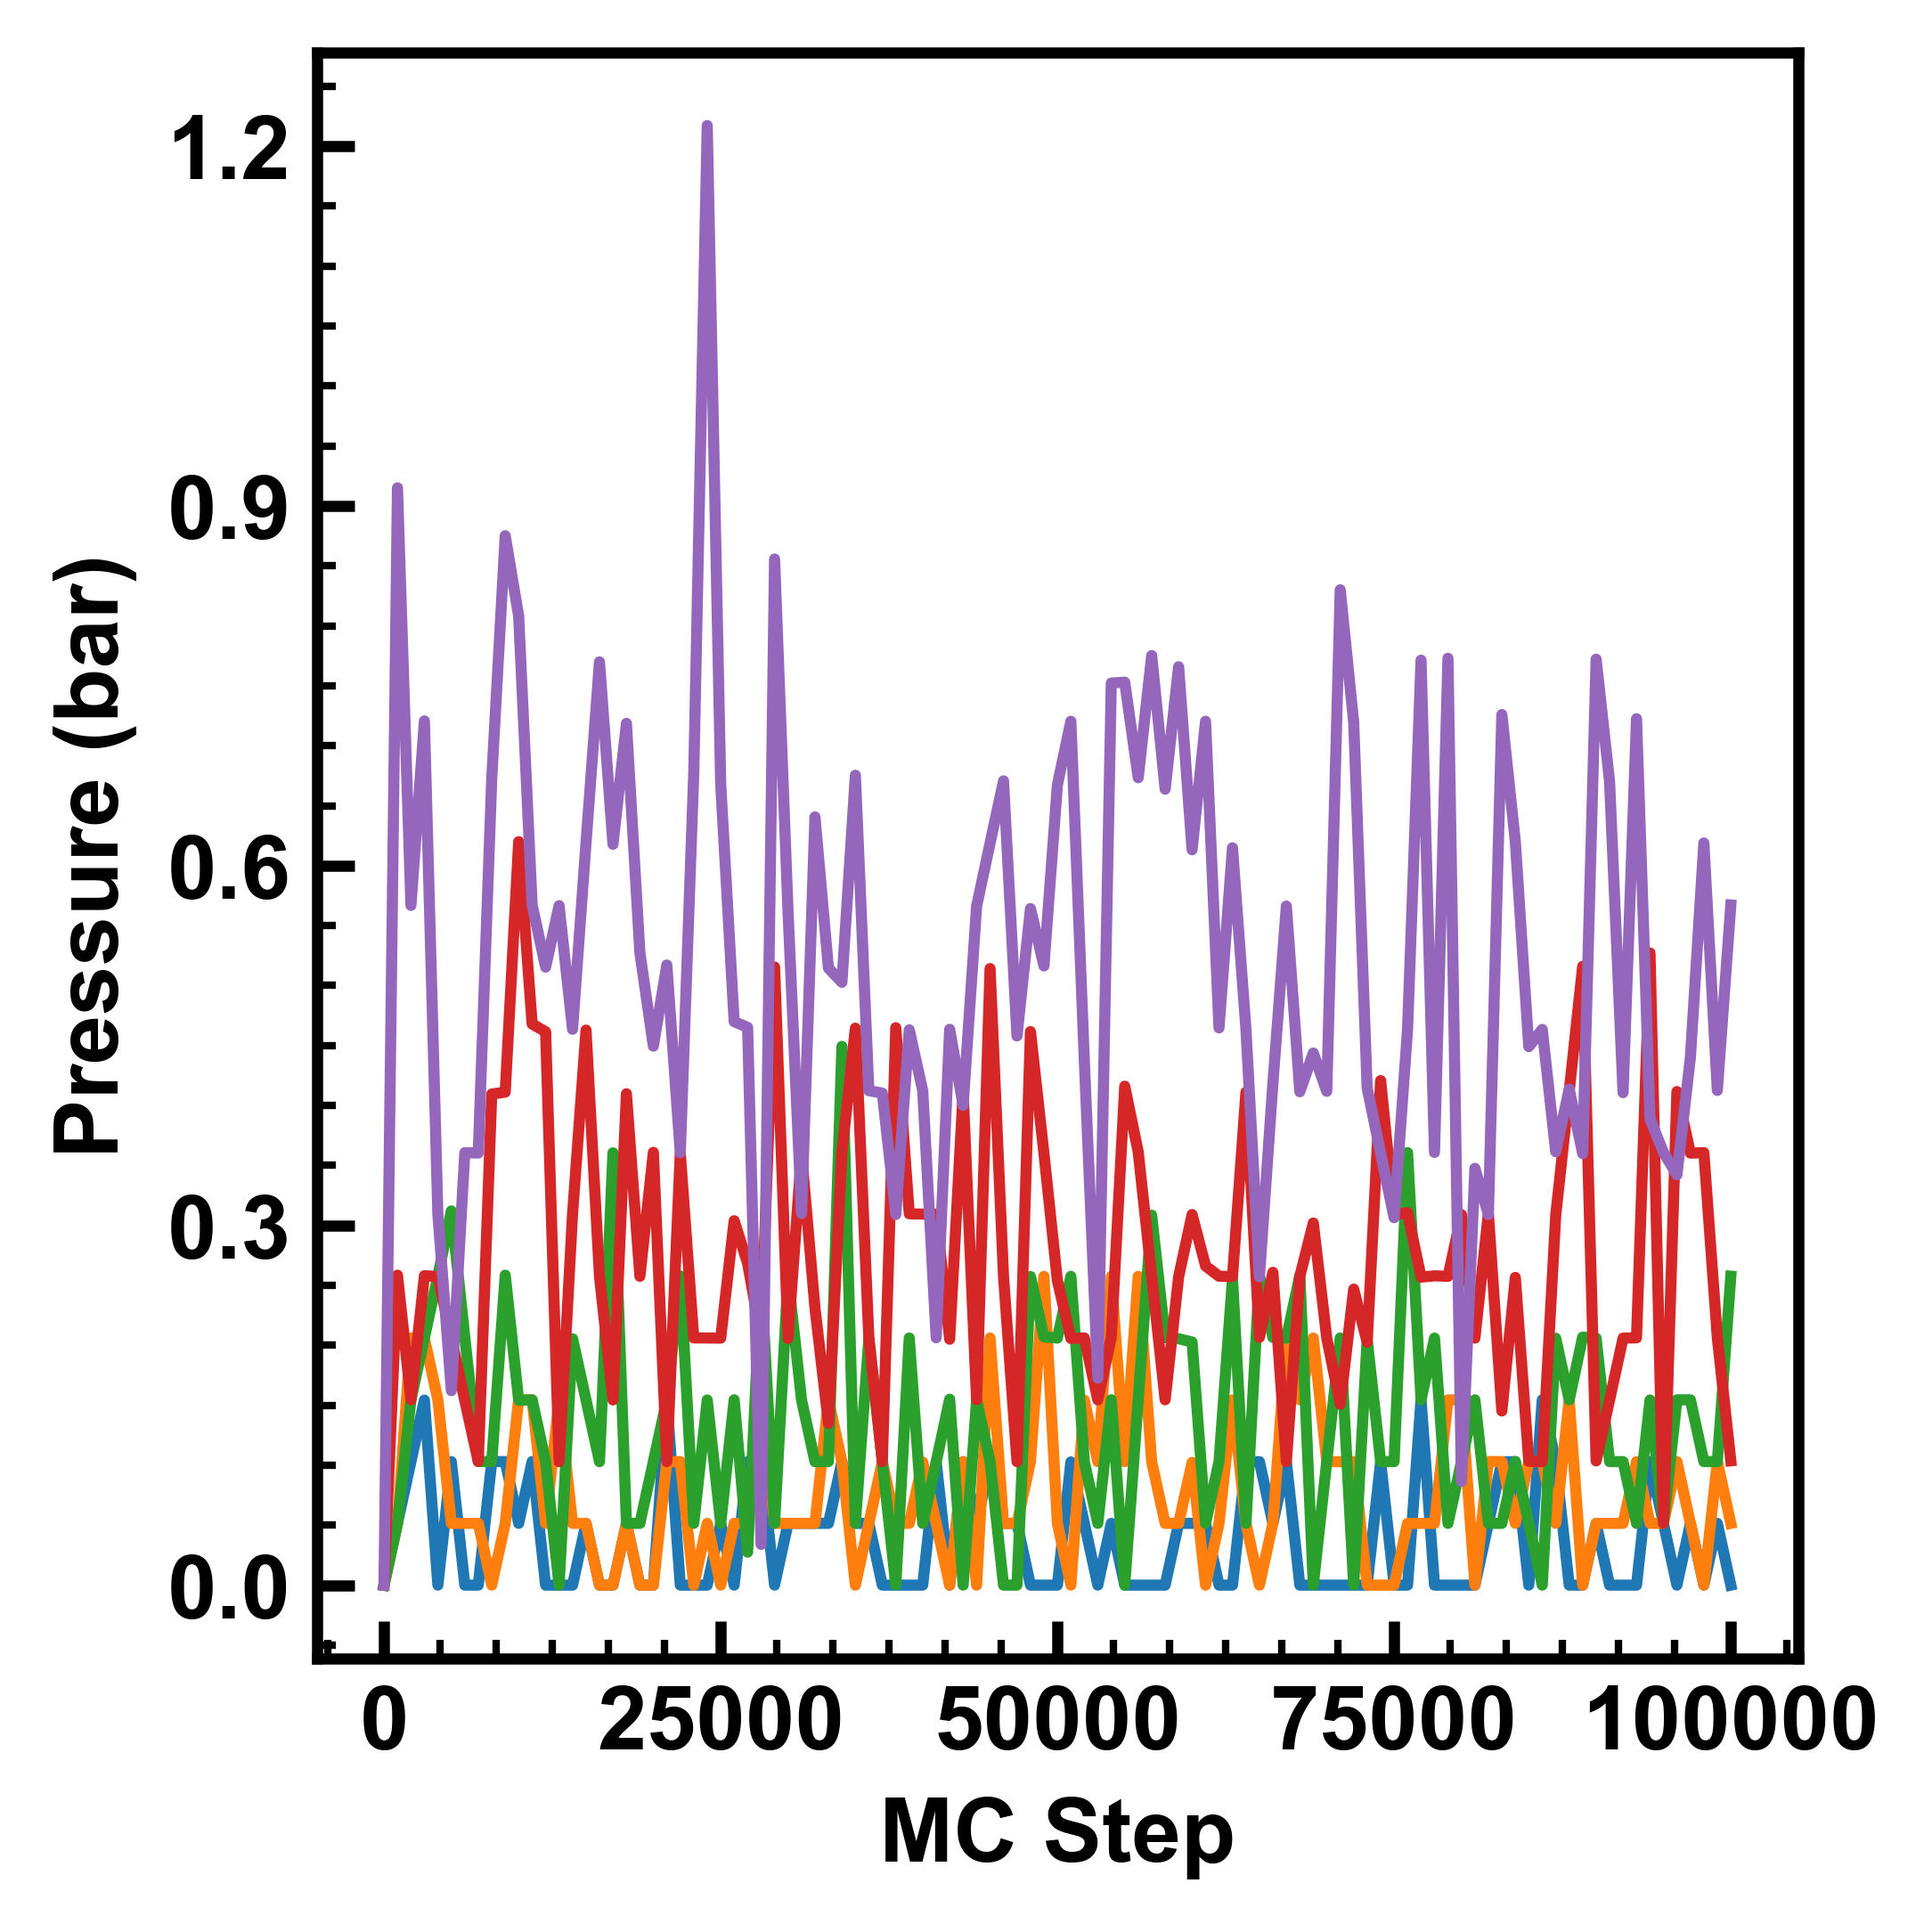

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (3.5, 3.5), layout = "constrained")

pressures = []
for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(dirname + "/gcmc.out.prp")
    pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure"))
    
ax.set_xlabel("MC Step")
ax.set_ylabel("Pressure (bar)")
set_ticks(ax,  xlinear=False, ylinear=False, xmax=True, ymax=True,)

pass

3.11853056385935
-47.92728551283005


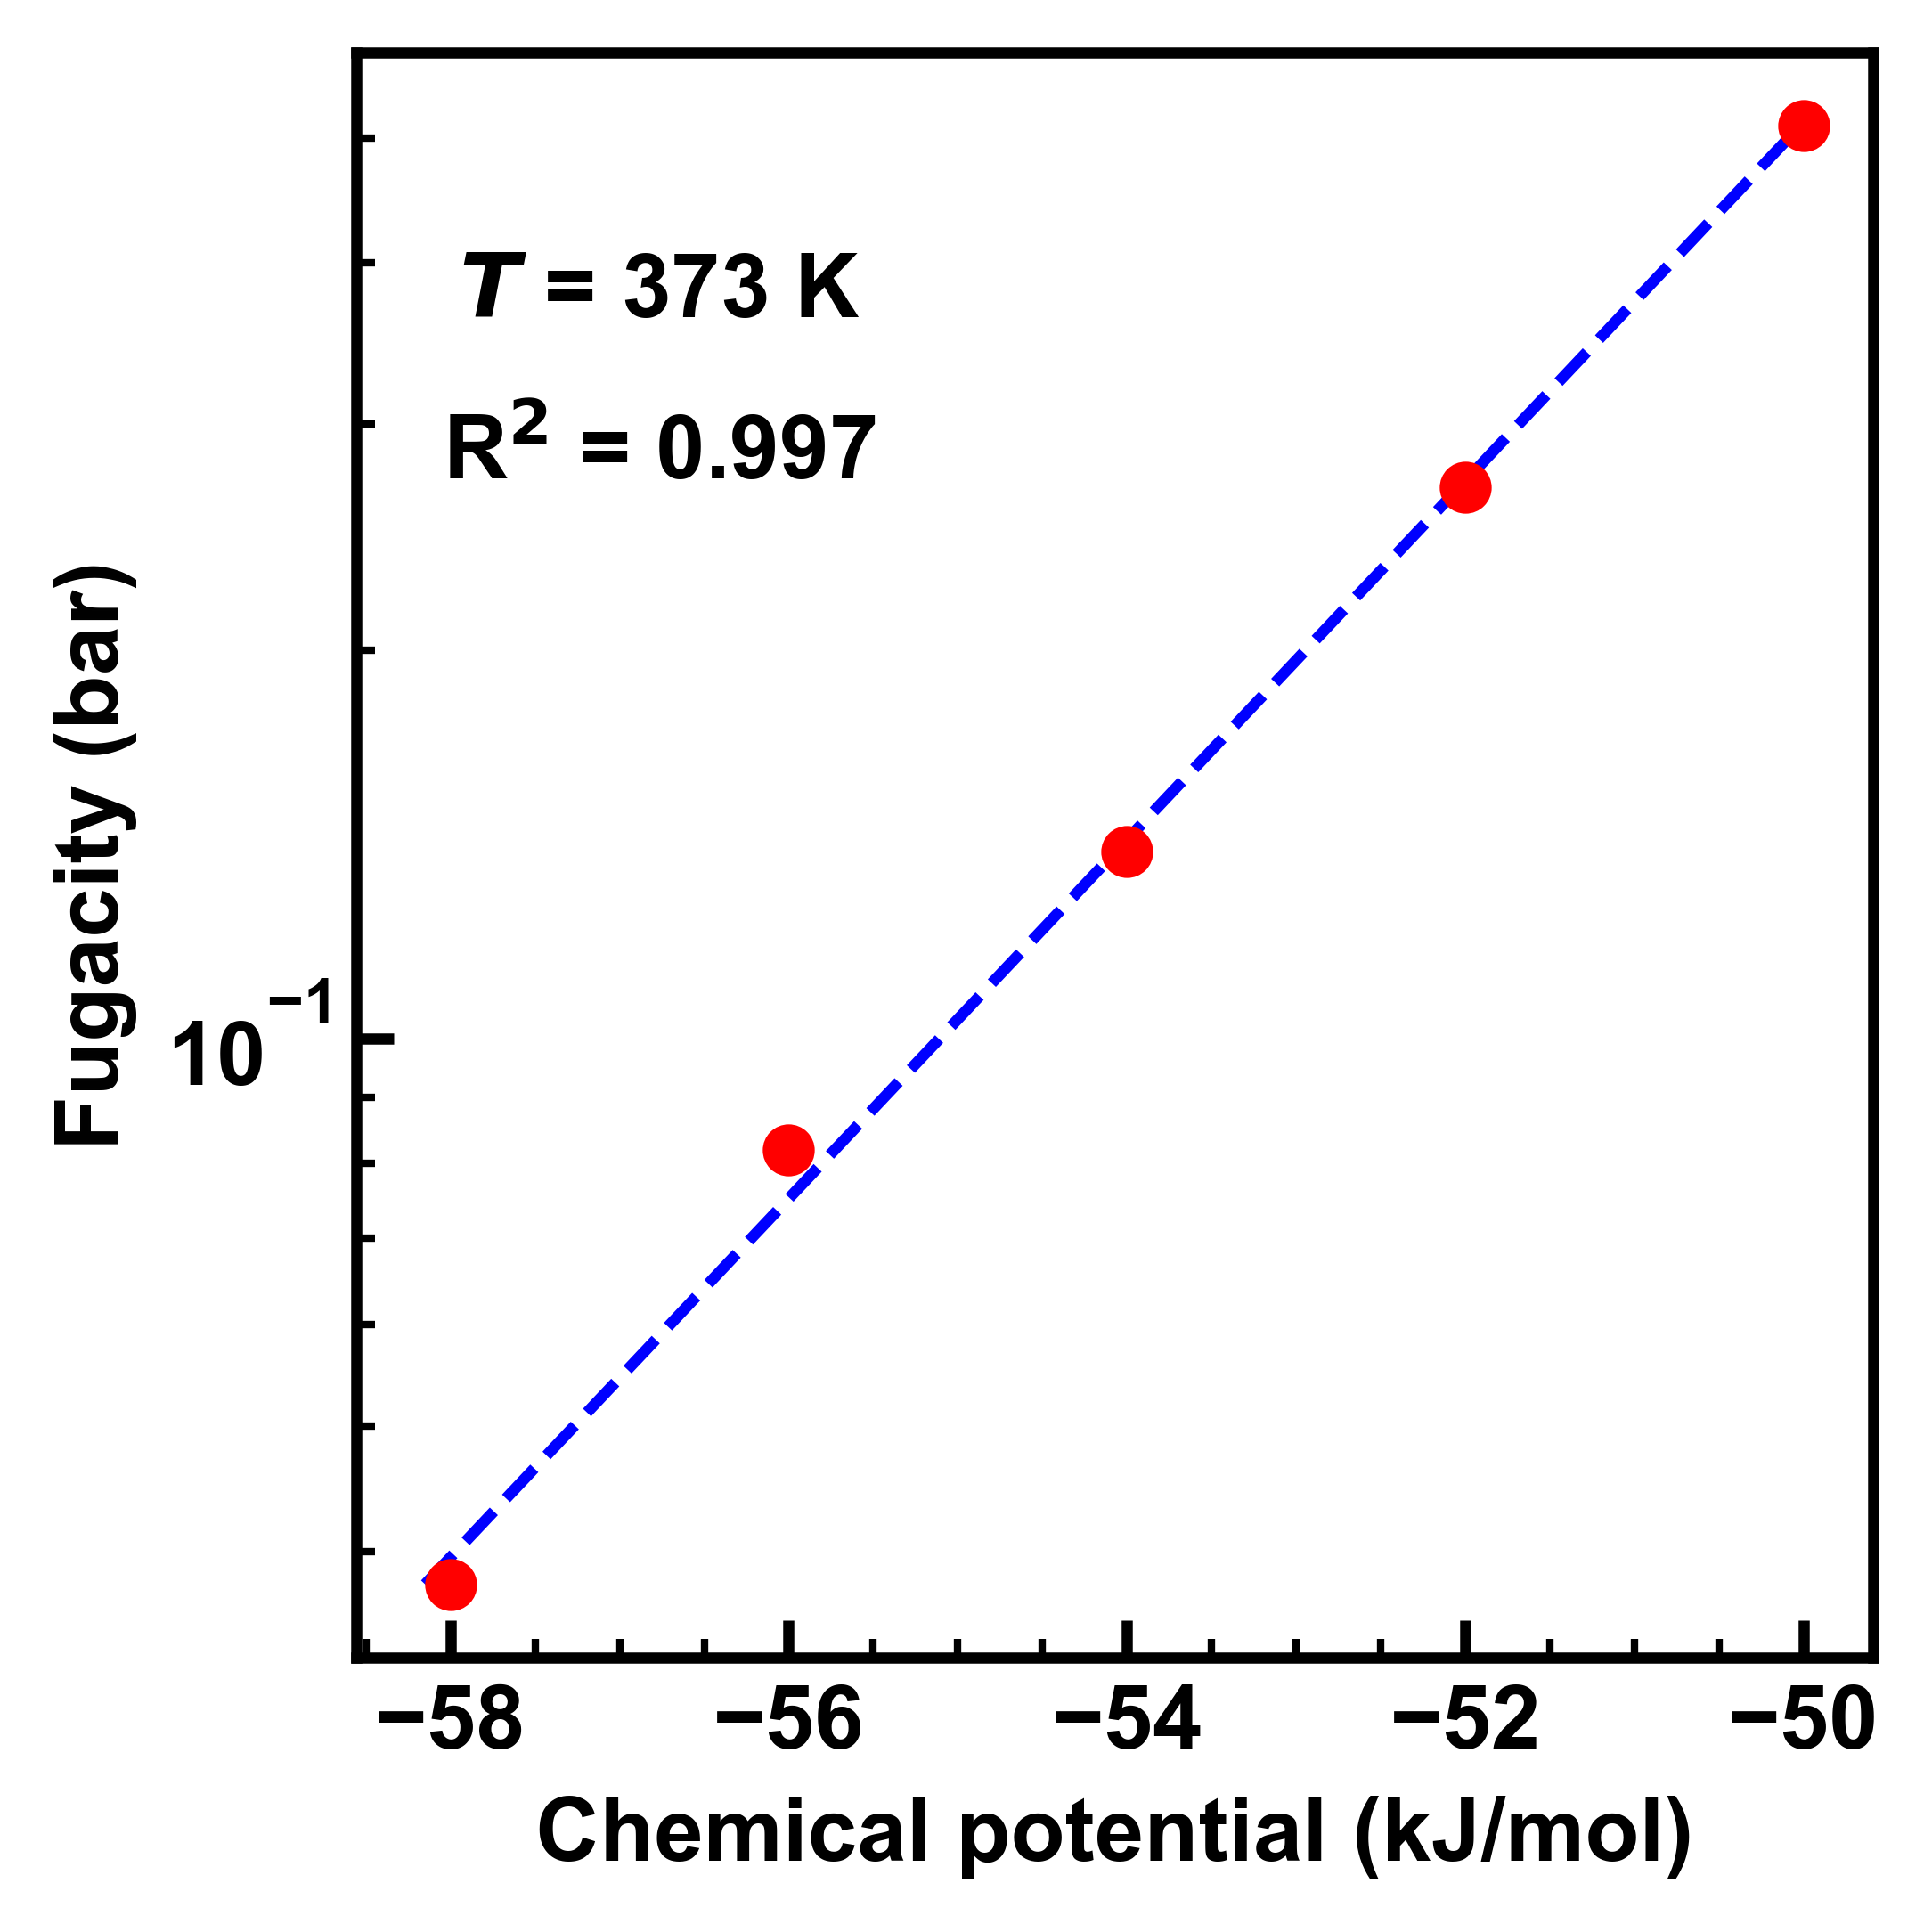

In [6]:


fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (3.5, 3.5), layout = "constrained")
slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())



mus_eos = (slope * np.log(pressures) + intercept) * u.kJ/u.mol
ax.plot(mus_eos, pressures, 'b--')

ax.plot(mus_adsorbate, pressures, 'ro')
ax.set_xlabel("Chemical potential (kJ/mol)")
ax.set_ylabel("Fugacity (bar)")
ax.set_yscale('log')


print(slope)
print(intercept)

ax.text(
        0.2, 0.85,
        f"$T$ = 373 K",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
    )


ax.text(
        0.2, 0.75,
        f"R$^2$ = {r_value * r_value:.3f}",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
    )


#fig.savefig("eos.png", transparent = True)
pass


In [12]:

pressures = [
    #6000   ,
    #22100  ,
    #49180  ,
    101325 , # 1 atmosphere
    #121800 ,
    #316800 ,
    #839700 ,
    #2243000,
    #6000000,
] * u.Pa

mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
for (mu, pressure) in zip(mus, pressures):
    print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f}")



We will run at mu = -47.89 kJ/mol to simulate 101325 Pa


In [14]:
custom_args = {
  "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 14.0 * u.angstrom,
    "charge_cutoff": 14.0 * u.angstrom,
    "prop_freq": 4000,
    "coord_freq": 4000,
    "angle_style": ['fixed'], # Only for riged molecules! 
}

mols_to_add = [[1000]]

for (pressure, mu) in zip(pressures, mus):
    dirname = f'pure_press_{pressure.value:0.0f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        box_list = [mb.Box([3.0, 3.0, 3.0])]
        
        species_list = [adsorbate_ff]
        system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
        moveset = mc.MoveSet('gcmc', species_list)
        moveset.prob_regrow = 0.0
        
        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=20000000,
            temperature=temperature,
            chemical_potentials = [mu],
            **custom_args
        )

Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


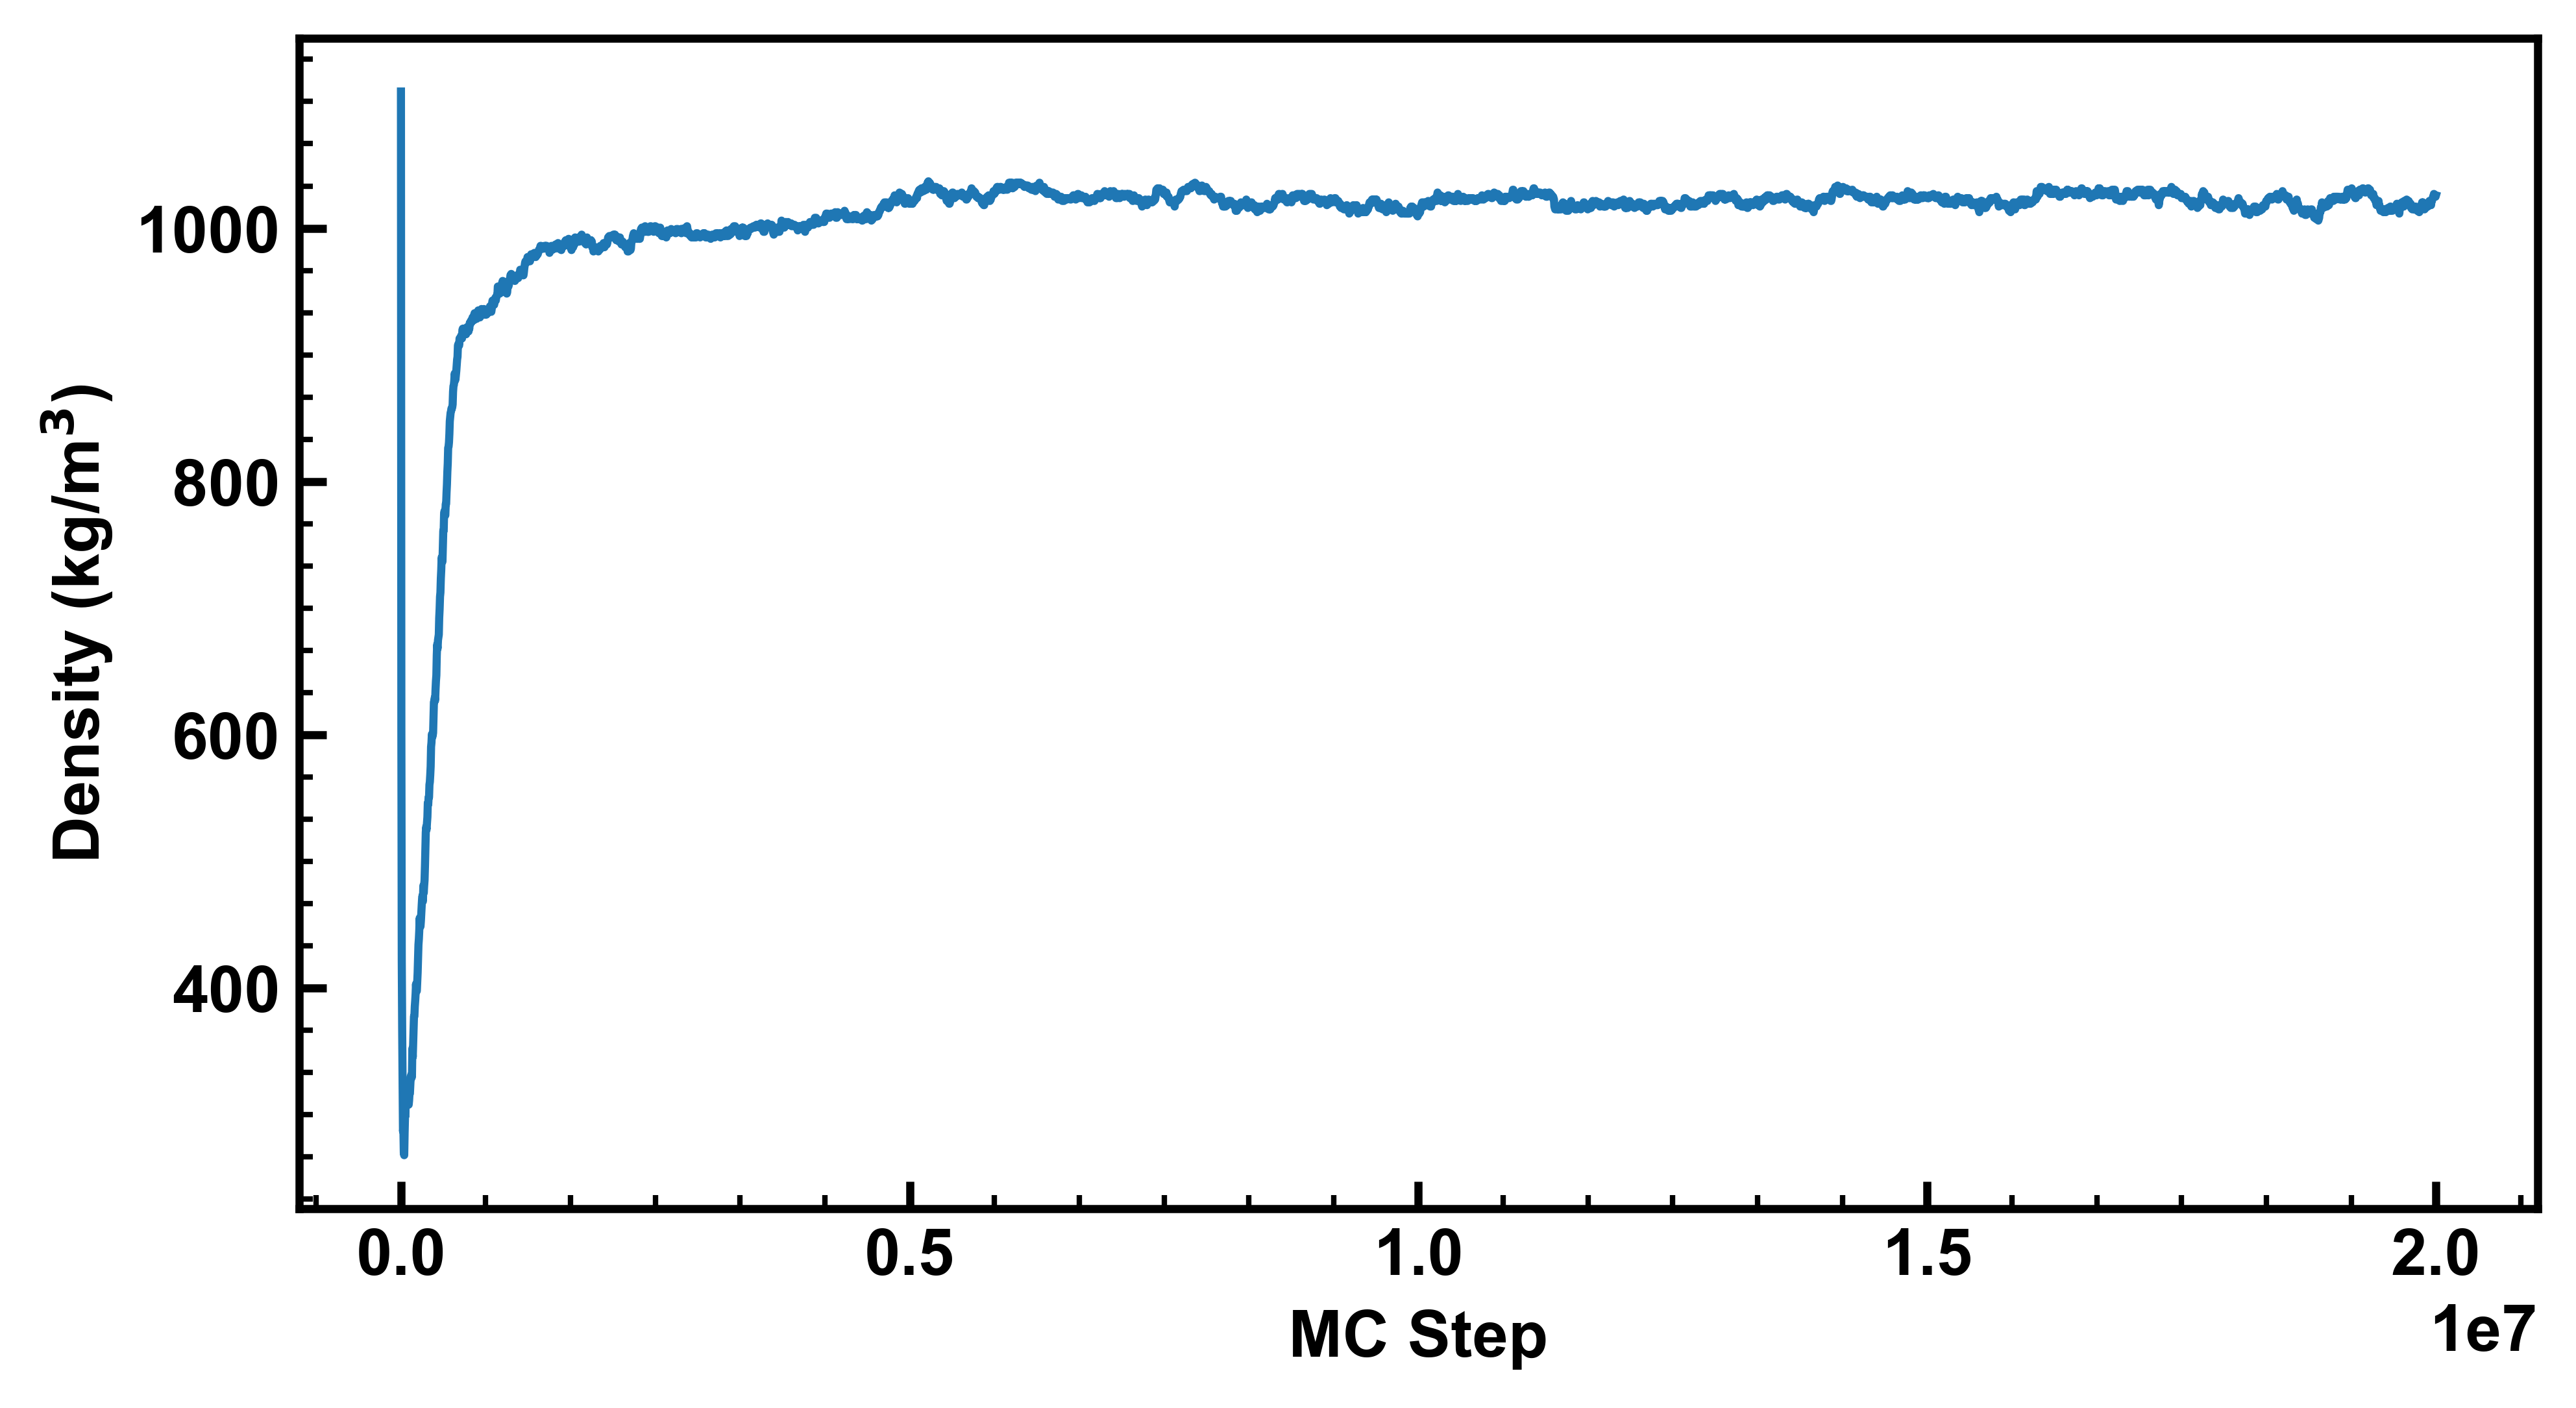

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600, figsize = (6.5, 3.5), layout = "constrained")
density = []
for pressure in pressures:
    dirname = f'pure_press_{pressure.value:0.0f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(f"{dirname}/gcmc.out.prp")
    density.append(np.mean(thermo.prop("Mass_Density", start=15000000)))
    ax.plot(thermo.prop("MC_STEP"), thermo.prop("Mass_Density"), label=f"{pressure:0.0f}")
    
#ax.set_title(f"T = {temperature:0.1f}", fontweight="bold")
ax.set_xlabel('MC Step')
ax.set_ylabel('Density (kg/m$^3$)')
set_ticks(ax,  xlinear=False, ylinear=False, xmax=True, ymax=True,)

#fig.legend(loc='outside center right', ncol=1)
fig.savefig("density.png", transparent = True)

In [17]:
for p, r in zip(pressures, density):
    mw = 18.015
    boxl  = ((mw / 6.022140857e23) / (r.value/1e30 * 1000.0))**(1 / 3.) # angstrom
    print(p, r, boxl)

101325 Pa 1022.2438790567547 dimensionless 3.081600099240985


In [18]:
3.081600099240985 * 4

12.32640039696394

In [19]:
# Run 1 more small NVT simulation to get a good initial set of starting coords, packmol is horrendous...

In [20]:
custom_args = {
  "rcut_min": 0.5 * u.angstrom,
    "vdw_cutoff": 5.0 * u.angstrom,
    "charge_cutoff": 5.0 * u.angstrom,
    "prop_freq": 10000,
    "coord_freq": 10000,
    "angle_style": ['fixed'], # Only for riged molecules! 
}

mols_to_add = [[64]]

for (pressure, mu) in zip(pressures, mus):
    dirname = f'nvt_pure_press_{pressure.value:0.0f}_T_{temperature:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        box_list = [mb.Box([3.081600099240985 * 0.4, 3.081600099240985 * 0.4, 3.081600099240985 * 0.4])]
        
        species_list = [adsorbate_ff]
        system = mc.System(box_list, species_list, mols_to_add=mols_to_add)
        moveset = mc.MoveSet('nvt', species_list)
        moveset.prob_regrow = 0.0
        
        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=10000,
            temperature=temperature,
            chemical_potentials = [mu],
            **custom_args
        )

Using the following executables for Cassandra:
Python: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/python
library_setup: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/Woody/Programs/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
